## Описание

Практика следующих тем:
- Парсинг
- Визуализация 
- Географическая визуализация

Предметная область данных:
- Фигурное катание

## Импорты

In [ ]:
# pip install beautifulsoup4 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install lxml


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Справка по предметной области

Современное оценивание соревнований по фигурному катанию представляет собой целый набор правил и формул для расчета итогового результата.
Каждый элемент оценивается судейской бригодой и техническими специалистами и приносит спортсмену определенную базовую стоимость (BV) и надбавки за качество (GOE).
Также отдельно оцениваются художественные "компоненты", тоже по определенным правилам. Спортсмен выступает два раза с разным набором элементов - с короткой и произвольной программой. Результат суммируется.
Такая система используется с 2004 года и называется "новой системой оценивания" или "новой системой судейства" (взамен "старой" - основаной на оценках типа "6.0")

Новая система судейства была нацелена на справедливость и снижение фактора субъективности в оценивании. При современном подходе итоговые протоколы оценивания позволяют не только выявить победителя, но и оценить вклад в его результат каждого отдельного элемента. Таким образом протоколы содержат достаточное количество данных, по которым можно собрать определенную статистику и провести некоторый анализ

Пример протокола судейства для короткой программы Ирины Слуцкой на чемпионате мира 2005 года

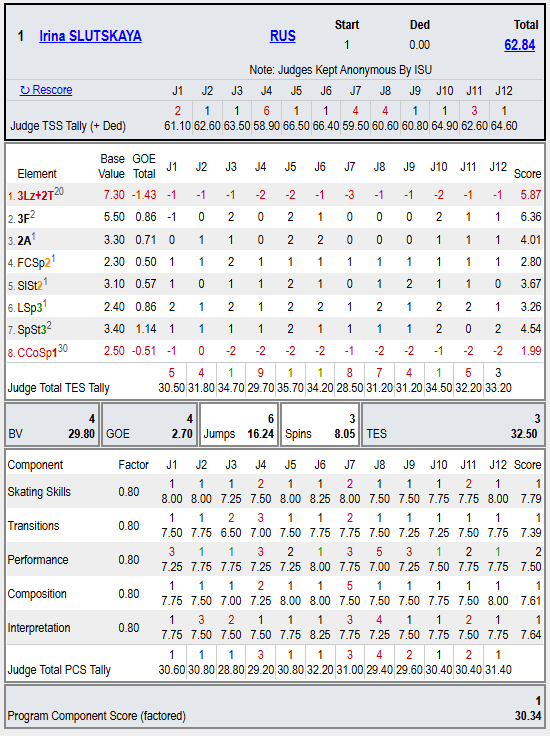


## Получение данных

В качестве источника взят сайт с официальными результатами соревнований по фигруному катанию в новой системе оценивания

Общий вид страницы выглядит следующим образом:

https://skatingscores.com/2425/wc/sr/women/i/short/usa/alysa_liu/

https://skatingscores.com/сезон/чемпионат/возрастная категория/дисциплина/i/программа/страна/участник/

Соберем информацию для чемпионатов мира за все года с новой системой оценивания в взрослом женском одиночном катании. Для этого нужно циклом пройтись по всем страницам и собрать нужные данные



In [ ]:
## Пример ссылки выглядит следующим образом: 'https://skatingscores.com/2425/wc/sr/women/i/short/'

## Нам нужно будет пройтись по всем годам
### Года указаны в ссылке как сезоны, то есть по парам с сезона 0405 до сезона 2425

## Рассматриваем только женщин, но нам нужны будут короткие и произвольные программы
# Таким образом нам нужен цикл для сбора ссылок

df_final = pd.DataFrame()
for i in tqdm(range(104,125), ncols=80, ascii=True, desc='Total'):
    season = str(i)[-2:]+str(i+1)[-2:]
    for program in ['long','short']:
        url = 'https://skatingscores.com/'+season+'/wc/sr/women/i/'+program+'/'
        page = requests.get(url)

        soup = BeautifulSoup(page.text, "html.parser")
        ## Каждая страницы содержит список участниц со отдельными ссылками на результаты каждой
        # Получаем все ссылки
        df_total_score = pd.DataFrame()
        for link in soup.find_all('a'):
            link_ = link.get('href')
            # Фильтруем ссылки участниц от ссылок на судей и прочих возможных по шаблону
            if '/wc/sr/women/i/' in link_:
                try:
                    country_girl = link_.split('/')[-3]
                    girl = link_.split('/')[-2]
                    # Собираем ссылку
                    girl_link = url+'/'+country_girl+'/'+girl+'/'
                    # print(girl_link)
                    page_girl = requests.get(girl_link)
                    # print(page_girl.status_code)    
                    soup_girl = BeautifulSoup(page_girl.text, "html.parser")
                    time.sleep(0.1)
                    # break
                    # Получаем все таблицы со страницы
                    ### Здесь много таблиц, так как в каждой представлена своя информация по различным оценкам иих состовляющим
                    tables = soup_girl.find_all('table')  
                    # Берем нужные нам параметры из каждой таблицы
                    # Здесь самая общая информация без подробных оценок за элементы
                    df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
                    df_2 = pd.read_html(str(tables[1]))[0]    
                    df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
                    df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
                    df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
                    df_4 = pd.read_html(str(tables[10]))[0]
                    df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
                    df_4['index'] = 1
                    df_4 = df_4.set_index(['index'])
                    df_first = df_1.join(df_2)
                    df_second = df_3.join(df_4)
                    df_all = df_first.join(df_second)
                    df_all = df_all.drop([0], axis=1)
                    df_total_score = pd.concat([df_total_score,df_all])  
                except:
                    pass
        # # Убираем лишние цифры
        df_total_score = df_total_score.replace(to_replace ='\d+\s', value = '', regex = True)
        df_total_score['Name'] = df_total_score['Name'].replace(to_replace ='\d+', value = '', regex = True)
        # Убираем лишние буквы
        df_total_score = df_total_score.replace(to_replace ='SB', value = '', regex = True) 
        df_total_score = df_total_score.replace(to_replace ='PB', value = '', regex = True) 
        # df_total_score = df_total_score[['Name','Country','Dedaction','Total','ISR 🇮🇱','SVK 🇸🇰','CZE 🇨🇿','FRA 🇫🇷','NOR 🇳🇴','SUI 🇨🇭','JPN 🇯🇵','ITA 🇮🇹','ROU 🇷🇴','BV','GOE','Jumps','Spins','TES','Component']]
        df_total_score['season'] = season
        df_total_score['program'] = program
        break
    df_final = pd.concat([df_total_score,df_final])  



Total:   0%|                                             | 0/21 [00:00<?, ?it/s]

In [1]:
df_final

NameError: name 'df_final' is not defined

## Черновое

In [ ]:
# df_final.to_excel('df_final.xlsx')

In [10]:
df_final


,Name,Country,3,Dedaction,Total,KAZ 🇰🇿,SLO 🇸🇮,CHN 🇨🇳,LAT 🇱🇻,CZE 🇨🇿,...,BV 23 27.13,BV 16 29.19,BVPB 29 26.23,BV 32 24.23,BV 35 23.00,BV 31 24.73,BV 34 23.03,BV 37 18.90,BV 33 23.33,BVSB 36 19.81
1,Alina ZAGITOVA,RUS,40,0.00,82.08,83.54,82.79,80.73,83.94,81.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alina ZAGITOVA,RUS,40,0.00,82.08,83.54,82.79,80.73,83.94,81.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kaori SAKAMOTO,JPN,35,0.00,76.86,75.38,77.63,78.10,74.70,77.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kaori SAKAMOTO,JPN,35,0.00,76.86,75.38,77.63,78.10,74.70,77.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Elizabet TURSYNBAYEVA,KAZ,32,0.00,75.96,78.30,77.94,71.95,74.81,76.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Isadora WILLIAMS,BRA,10,0.00,42.16,NaN,39.60,NaN,NaN,44.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOE -0.55,NaN,NaN
1,Antonina DUBININA,SRB,13,0.00,41.40,NaN,40.03,NaN,NaN,41.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOE -2.53,NaN
1,Antonina DUBININA,SRB,13,0.00,41.40,NaN,40.03,NaN,NaN,41.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOE -2.53,NaN
1,Angelina KUCHVALSKA,LAT,7,-1.00,35.78,NaN,35.11,NaN,NaN,37.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOE -3.57


In [ ]:
# Получаем все ссылки
df_total_score = pd.DataFrame()
for link in soup.find_all('a'):
    link_ = link.get('href')
    # Фильтруем ссылки участниц от ссылок на судей и прочих возможных по шаблону
    if '/re/2425/wc/sr/women/i/short' in link_:
        country_girl = link_.split('/')[-3]
        girl = link_.split('/')[-2]
        # Собираем ссылку
        girl_link = base_link+'/'+country_girl+'/'+girl+'/'
        # print(girl_link)
        page_girl = requests.get(girl_link)
        # print(page_girl.status_code)    
        soup_girl = BeautifulSoup(page_girl.text, "html.parser")
        time.sleep(3)
        # break
        # Получаем все таблицы со страницы
        ### Здесь много таблиц, так как в каждой представлена своя информация по различным оценкам иих состовляющим
        tables = soup_girl.find_all('table')  
        # Берем нужные нам параметры из каждой таблицы
        # Здесь самая общая информация без подробных оценок за элементы
        df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
        df_2 = pd.read_html(str(tables[1]))[0]    
        df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
        df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
        df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
        df_4 = pd.read_html(str(tables[10]))[0]
        df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
        df_4['index'] = 1
        df_4 = df_4.set_index(['index'])
        df_first = df_1.join(df_2)
        df_second = df_3.join(df_4)
        df_all = df_first.join(df_second)
        df_all = df_all.drop([0], axis=1)
        df_total_score = pd.concat([df_total_score,df_all])  
# # Убираем лишние цифры
df_total_score = df_total_score.replace(to_replace ='\d+\s', value = '', regex = True)
df_total_score['Name'] = df_total_score['Name'].replace(to_replace ='\d+', value = '', regex = True)
# Убираем лишние буквы
df_total_score = df_total_score.replace(to_replace ='SB', value = '', regex = True) 
df_total_score = df_total_score.replace(to_replace ='PB', value = '', regex = True) 
df_total_score = df_total_score[['Name','Country','Dedaction','Total','ISR 🇮🇱','SVK 🇸🇰','CZE 🇨🇿','FRA 🇫🇷','NOR 🇳🇴','SUI 🇨🇭','JPN 🇯🇵','ITA 🇮🇹','ROU 🇷🇴','BV','GOE','Jumps','Spins','TES','Component']]


In [122]:
df_total_score

,Name,Country,Dedaction,Total,ISR 🇮🇱,SVK 🇸🇰,CZE 🇨🇿,FRA 🇫🇷,NOR 🇳🇴,SUI 🇨🇭,JPN 🇯🇵,ITA 🇮🇹,ROU 🇷🇴,BV,GOE,Jumps,Spins,TES,Component
1,Alysa LIU,USA,0.00,74.58,77.23,75.71,73.06,72.85,74.68,73.65,73.92,75.45,74.65,32.59,8.21,22.76,12.75,40.80,33.78
1,Mone CHIBA,JPN,0.00,73.44,72.79,73.43,71.87,74.15,74.57,75.04,71.86,75.10,74.04,31.93,7.41,22.27,12.59,39.34,34.10
1,Isabeau LEVITO,USA,0.00,73.33,74.18,75.19,73.28,68.65,70.59,75.11,74.12,74.73,71.42,32.59,6.68,21.50,12.37,39.27,34.06
1,Wakaba HIGUCHI,JPN,0.00,72.10,77.62,69.52,71.46,65.98,73.39,71.40,72.11,73.73,72.71,32.33,7.38,22.71,11.48,39.71,32.39
1,Kaori SAKAMOTO,JPN,0.00,71.03,72.33,68.51,69.59,69.94,71.47,71.76,71.47,71.44,70.87,28.00,7.99,19.73,11.64,35.99,35.04
1,Madeline SCHIZAS,CAN,0.00,69.18,69.13,68.18,70.23,68.19,67.20,70.00,69.22,70.70,68.77,31.89,6.56,22.40,11.09,38.45,30.73
1,Haein LEE,KOR,0.00,67.79,69.95,62.66,68.77,65.59,67.56,68.62,67.89,69.63,68.32,32.33,4.56,20.45,11.20,36.89,30.90
1,Nina PINZARRONE,BEL,0.00,67.74,68.87,66.63,68.91,66.96,68.62,68.64,64.87,66.96,67.74,32.09,4.11,19.32,11.87,36.20,31.54
1,Amber GLENN,USA,-1.00,67.65,69.19,61.78,68.82,64.77,67.68,68.18,66.83,69.68,69.39,34.89,1.02,20.95,10.72,35.91,32.74
1,Kimmy REPOND,SUI,0.00,67.42,69.54,62.33,67.54,68.60,64.93,70.87,66.52,68.73,66.13,30.89,5.58,20.74,11.58,36.47,30.95


### Проходимся по странице

In [31]:
# Получаем все таблицы со страницы
tables = soup_girl.find_all('table')

In [ ]:
# Из первой таблицы оставляем имя, страну, дедакшен(штраф) и итоговую сумму баллов
df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
df_2 = pd.read_html(str(tables[1]))[0]    
df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
df_4 = pd.read_html(str(tables[10]))[0]
df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
df_4['index'] = 1
df_4 = df_4.set_index(['index'])
df_first = df_1.join(df_2)
df_second = df_3.join(df_4)
df_all = df_first.join(df_second)
df_all = df_all.drop([0], axis=1)
df_all

In [79]:
## Все таблицы надо привести к формату для анализа, оставив только нужные показатели

# В итоге должно получится две таблицы - в разрезе общих результатов и подробно по элементам

# Из первой таблицы оставляем имя, страну, дедакшен(штраф) и итоговую сумму баллов
df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
# df_1 = df_1.drop([3], axis=1).reset_index()
# df_1 = df_1.drop(['index'], axis=1)
df_1


C:\Users\пользователь\AppData\Local\Temp\ipykernel_11032\780115722.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})


,0,Name,Country,3,Dedaction,Total
1,33,Anastasia GOZHVA76,UKR,4,-2.00,37.54


In [82]:
# Во второй TSS по судьям
df_2 = pd.read_html(str(tables[1]))[0]    
df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
# Убираем лишние цифры
# df_2 = df_2.replace(to_replace ='\d{1}\s', value = '', regex = True)
# df_2 = df_2.drop(['index'], axis=1)   
df_2      


C:\Users\пользователь\AppData\Local\Temp\ipykernel_11032\459431234.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_2 = pd.read_html(str(tables[1]))[0]


,ISR 🇮🇱,SVK 🇸🇰,CZE 🇨🇿,FRA 🇫🇷,NOR 🇳🇴,SUI 🇨🇭,JPN 🇯🇵,ITA 🇮🇹,ROU 🇷🇴
1,33 36.51,33 37.10,33 39.52,33 36.19,32 39.40,33 35.48,33 39.06,33 36.22,32 37.83


In [83]:
## Из этой таблицы возьмем техническую разбивку - BV, GOE, Jumps, Spins, TES
df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
# Убираем лишние цифры
# df_3  = df_3.replace(to_replace ='\d{1}\s', value = '', regex = True)
# Убираем лишние буквы
# df_3  = df_3.replace(to_replace ='SB', value = '', regex = True)
# df_3 = df_3.drop(['BVSB 2 32.59'], axis=1).reset_index()
# df_3 = df_3.drop(['index'], axis=1)
# df_3 = df_3[['BV','GOE','Jumps','Spins','TES']]
df_3

C:\Users\пользователь\AppData\Local\Temp\ipykernel_11032\4161011731.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T


,BV 29 24.95,BV,GOE,Jumps,Spins,TES
1,GOE 32 -4.90,29 24.95,32 -4.90,33 7.03,24 9.72,31 20.05


In [97]:
df_4 = pd.read_html(str(tables[10]))[0]
# df_4  = df_4.replace(to_replace ='\d{1}\s', value = '', regex = True)
# df_4  = df_4.replace(to_replace ='PB', value = '', regex = True)
# df_4 = df_4[[15]]
df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
df_4['index'] = 1
# df_4 = df_4.drop(['index'], axis=1)
df_4 = df_4.set_index(['index'])

C:\Users\пользователь\AppData\Local\Temp\ipykernel_11032\4108294425.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_4 = pd.read_html(str(tables[10]))[0]


In [96]:
df_first = df_1.join(df_2)
df_second = df_3.join(df_4)
df_all = df_first.join(df_second)
df_all = df_all.drop([0], axis=1)
df_all

,Name,Country,3,Dedaction,Total,ISR 🇮🇱,SVK 🇸🇰,CZE 🇨🇿,FRA 🇫🇷,NOR 🇳🇴,...,JPN 🇯🇵,ITA 🇮🇹,ROU 🇷🇴,BV 29 24.95,BV,GOE,Jumps,Spins,TES,Component
1,Anastasia GOZHVA76,UKR,4,-2.00,37.54,33 36.51,33 37.10,33 39.52,33 36.19,32 39.40,...,33 39.06,33 36.22,32 37.83,GOE 32 -4.90,29 24.95,32 -4.90,33 7.03,24 9.72,31 20.05,33 19.49


In [ ]:
# Элементы подробно

# ## Третья - оценки за элементы по технике
# df_3 = pd.read_html(str(tables[2]))[0]

# pd.read_html(str(tables[9]))[0]